In [2]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler

In [3]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [4]:
df = pd.read_csv(DATASET)

categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(columns=categorical_attr_list)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))

df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,158558,0.145081,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,-0.005890,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
2,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

In [6]:
TARGET = 'stft_min'

# drop quantile columns with high percentage of zeros (20%)
zero_percentage = (df_reg == 0).mean()
to_drop = [col for col in df_reg.columns if zero_percentage[col] > 0.2 and re.search(r'q\d{2}', col)]
df_reg = df_reg.drop(columns=to_drop)
to_drop

['mfcc_q50',
 'sc_q01',
 'sc_q05',
 'stft_q01',
 'stft_q05',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'sc_q05_w1',
 'sc_q25_w1',
 'stft_q05_w1',
 'q50_w2',
 'q50_w3',
 'lag1_q50_w3',
 'q75_w4']

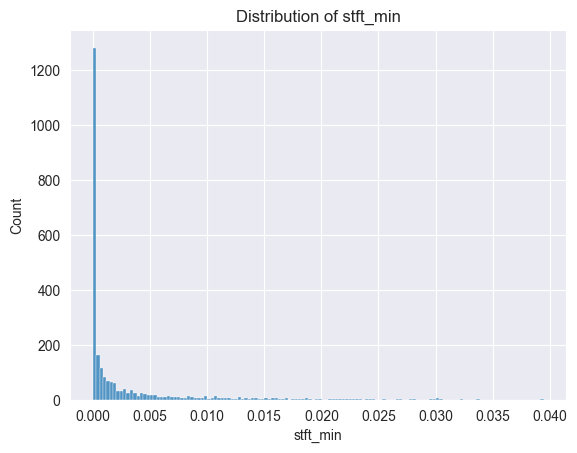

In [7]:
sns.histplot(data=df, x=df[TARGET])
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg[TARGET] == 0]
df_nz = df_reg[df_reg[TARGET] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

df_train = df_nz[:split_index]
df_test = df_nz[split_index:]

df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=100)

y_train = np.log10(df_train[TARGET].to_numpy())
y_valid = np.log10(df_valid[TARGET].to_numpy())
y_test = np.log10(df_test[TARGET].to_numpy())

df_zero = df_zero.drop([TARGET], axis=1)
df_train = df_train.drop([TARGET], axis=1)
df_valid = df_valid.drop([TARGET], axis=1)
df_test = df_test.drop([TARGET], axis=1)

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_valid = df_valid.to_numpy()
X_test = df_test.to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape, X_to_pred.shape)

(847, 270) (212, 270) (361, 270) (1009, 270)


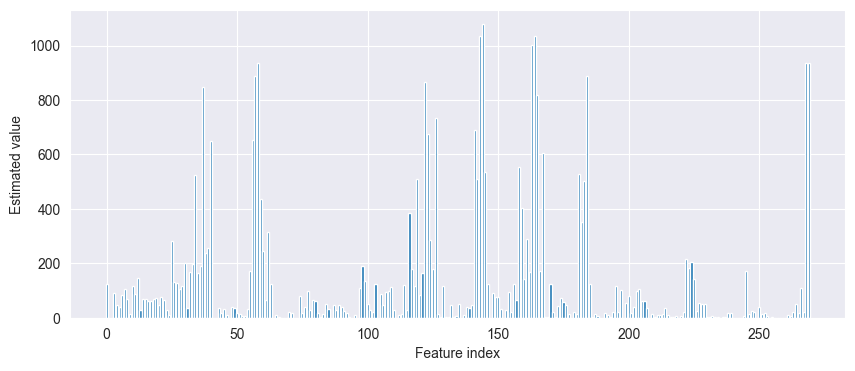

In [9]:
f_selector = SelectKBest(score_func=f_regression, k='all')
f_selector.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated value')
plt.show()

In [10]:
f_selector = SelectKBest(score_func=f_regression, k=20)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_train.iloc[:, selected_indices]

,mfcc_q25,mfcc_q99,stft_mean,stft_std,stft_q25,mfcc_q25_w2,mfcc_q50_w2,mfcc_q99_w2,stft_sum_w2,stft_q05_w2,stft_q25_w2,stft_skew_w2,mfcc_sum_w3,mfcc_q25_w3,mfcc_q50_w3,mfcc_q75_w3,mfcc_q99_w3,stft_q25_w3,sex_F,sex_M
259,-18.582673,133.537021,0.391166,0.350493,0.037039,-25.548968,-14.335812,131.763970,316.827272,0.002076,0.019907,1.368237,-70611.711781,-25.377122,-12.167407,-1.477520,141.949765,0.006469,1,0
157,-2.432008,140.389436,0.618064,0.281252,0.400627,-11.883626,0.331137,157.141432,487.714941,0.047736,0.247174,-0.016021,-37384.776127,-9.452207,0.308263,9.277478,208.015807,0.228734,0,1
667,-10.434671,169.611666,0.499650,0.347630,0.142961,-18.150980,-7.070016,177.324767,409.154710,0.007334,0.053486,0.865939,-39253.197492,-17.626914,-5.782738,6.776643,182.314767,0.089444,0,1
707,-11.989990,140.775630,0.500564,0.321720,0.203172,-19.689170,-6.076445,132.367535,424.497157,0.012076,0.085660,0.328339,-46073.398204,-21.128508,-10.204088,2.029520,174.004688,0.052809,1,0
125,-6.579166,90.324497,0.475922,0.349201,0.106374,-15.118881,0.000000,92.440168,351.456816,0.002707,0.027473,0.804747,-39812.423944,-25.070787,-7.274005,9.855553,124.347880,0.013650,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,-10.531611,188.840487,0.448354,0.342674,0.105303,-16.788827,-4.730709,181.582949,469.988087,0.016418,0.071749,0.886020,-54877.142055,-18.882193,-4.978764,7.866954,207.137736,0.043049,0,1
53,-10.841864,159.482310,0.512951,0.316919,0.221845,-20.016054,-4.384253,176.553050,452.237700,0.045298,0.156050,0.706239,-30872.660059,-18.504748,-4.311820,10.084295,166.648179,0.122665,0,1
350,-7.651122,151.113206,0.543641,0.328328,0.233966,-13.594585,-2.200245,156.181359,492.584031,0.025636,0.164514,0.347103,-38947.164248,-17.357152,-6.596020,6.551662,192.158127,0.081348,1,0
79,-10.683922,143.316089,0.513574,0.286984,0.275286,-11.417866,-2.853683,147.437486,577.809521,0.057310,0.276032,0.175891,-37772.767541,-16.525048,-5.833418,5.294950,171.602208,0.172040,0,1


In [11]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)

## XGBoost

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=100, n_jobs=-1)

[I 2023-06-06 18:55:17,594] A new study created in memory with name: no-name-cbe8de46-b1b7-4c12-9ff4-e1b2b34b77ce
[I 2023-06-06 18:55:19,529] Trial 4 finished with value: 0.11796647465753987 and parameters: {'booster': 'gbtree', 'gamma': 1.7037425866491451, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.4156858596445524}. Best is trial 4 with value: 0.11796647465753987.
[I 2023-06-06 18:55:20,859] Trial 0 finished with value: 0.10250763442487572 and parameters: {'booster': 'gbtree', 'gamma': 3.9110924420764532, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.9427092505420954}. Best is trial 0 with value: 0.10250763442487572.
[I 2023-06-06 18:55:21,260] Trial 7 finished with value: 0.10851934395318798 and parameters: {'booster': 'dart', 'gamma': 3.960382159131991, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8149627386308748}. Best is trial 0 with value: 0.10250763442487572.
[I 2023-06-06 18:55:22,047] Trial 5 finished with value: 0.09984923142932843 and parameter

In [13]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'gbtree', 'gamma': 2.6097726072333662, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.7908633556878183}
Root mean squared error = 0.3973
R-squared = 0.6552


In [14]:
y_pred = xgb.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([0.01002509, 0.01002509, 0.00939152, ..., 0.00018898, 0.00011112,
       0.00011112], dtype=float32)

In [15]:
# negative values predicted
np.count_nonzero(y_pred < 0)

0

In [16]:
df_zero[TARGET] = y_pred
df.update(df_zero)

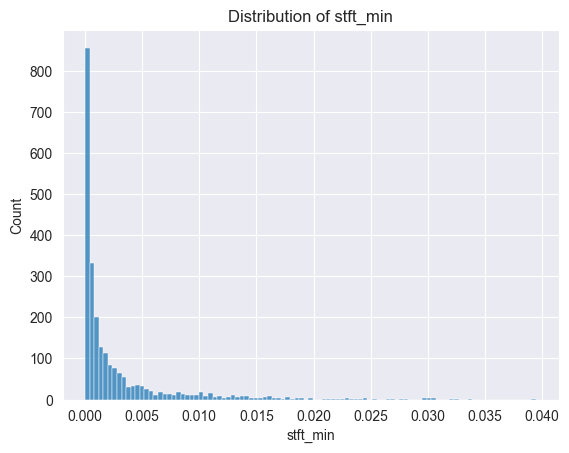

In [17]:
sns.histplot(data=df, x=TARGET)
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

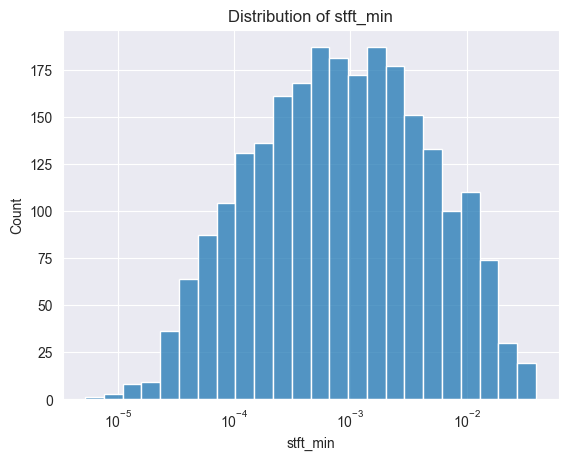

In [18]:
sns.histplot(data=df, x=TARGET, log_scale=True)
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

## Neural Network

In [19]:
import tensorflow
from keras import Sequential
from keras.layers import Dense

def create_model(trial):

    n_hidden = trial.suggest_int('n_hidden', 1, 3)
    n_units = trial.suggest_int('n_units', 32, 128)
    learn_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)

    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train.shape[1], activation='relu'))

    for i in range(n_hidden):
        model.add(Dense(n_units, activation='relu'))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learn_rate),
                  metrics=tensorflow.keras.metrics.MeanSquaredError())
    return model


# objective function to be minimized
def objective_fun(trial):

    model = create_model(trial)
    model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_valid, y_valid), verbose=False)

    error = model.evaluate(X_valid, y_valid, verbose=False)[1]

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=100, n_jobs=-1)

[I 2023-06-06 18:56:10,204] A new study created in memory with name: no-name-cb0c9579-e81e-45d7-8d72-36621dfda84b


[I 2023-06-06 18:56:13,010] Trial 6 finished with value: 0.14700718224048615 and parameters: {'n_hidden': 1, 'n_units': 57, 'learning_rate': 0.050216681313764604}. Best is trial 6 with value: 0.14700718224048615.
[I 2023-06-06 18:56:13,014] Trial 7 finished with value: 0.16439925134181976 and parameters: {'n_hidden': 1, 'n_units': 58, 'learning_rate': 0.04244036258415641}. Best is trial 6 with value: 0.14700718224048615.
[I 2023-06-06 18:56:13,061] Trial 3 finished with value: 0.224782332777977 and parameters: {'n_hidden': 1, 'n_units': 110, 'learning_rate': 0.07382860955648406}. Best is trial 6 with value: 0.14700718224048615.
[I 2023-06-06 18:56:13,129] Trial 1 finished with value: 0.202677384018898 and parameters: {'n_hidden': 1, 'n_units': 94, 'learning_rate': 0.0004715473813257265}. Best is trial 6 with value: 0.14700718224048615.
[I 2023-06-06 18:56:13,193] Trial 2 finished with value: 0.12603917717933655 and parameters: {'n_hidden': 2, 'n_units': 51, 'learning_rate': 0.047070178

In [20]:
model = create_model(study.best_trial)
model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_valid, y_valid), verbose=False)

y_pred_test = model.predict(X_test)

print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

12/12 [==============================] - 0s 370us/step
Root mean squared error = 0.5130
R-squared = 0.4250


In [21]:
y_pred = model.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

32/32 [==============================] - 0s 372us/step


array([[0.0197151 ],
       [0.02003535],
       [0.01469635],
       ...,
       [0.00014938],
       [0.00015547],
       [0.00013633]], dtype=float32)